In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from google.colab.patches import cv2_imshow
from scipy.ndimage import generic_filter
from google.colab import drive
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


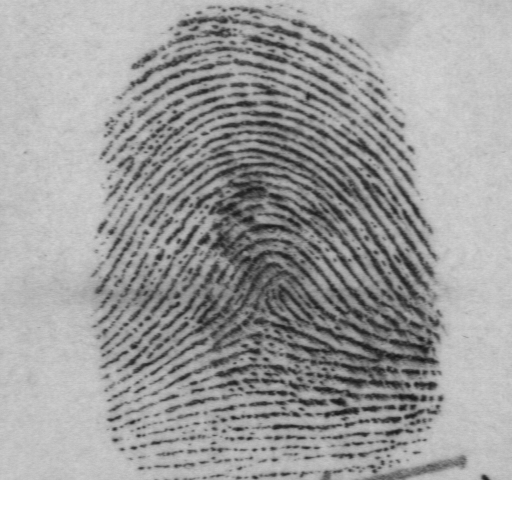

In [6]:
img=cv2.imread('/content/drive/MyDrive/imgprocessing_project/Images dataset2/Nour/T_f0731_02.png', cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

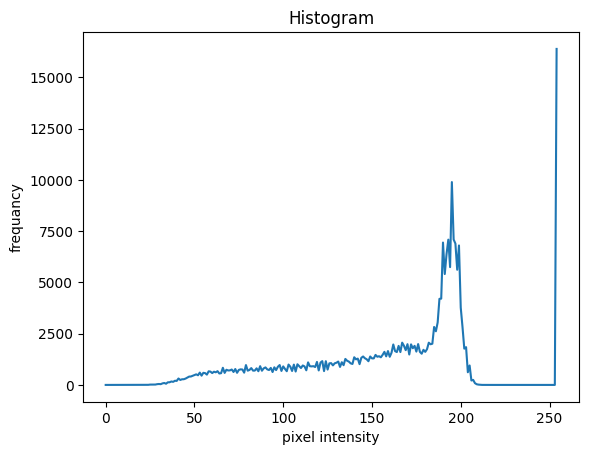

In [7]:
hist= cv2.calcHist([img],[0],None,[255],[0,256])

plt.plot(hist)
plt.title('Histogram')
plt.xlabel('pixel intensity')
plt.ylabel('frequancy')
plt.show()

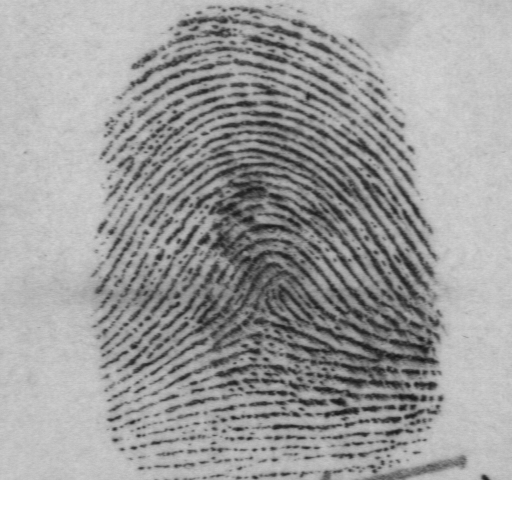

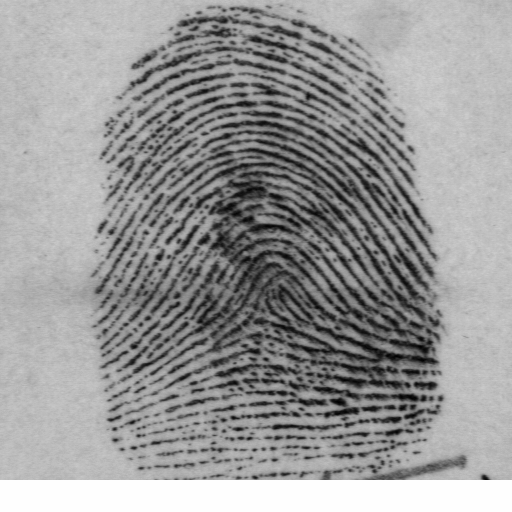

In [8]:
r_min=np.min(img)
r_max=np.max(img)
s_min=0
s_max=255
# constrast stretching
stretched1= ((img-r_min)*((s_max-s_min)/(r_max-r_min))+s_min).astype(np.uint8)

cv2_imshow(img)
cv2_imshow(stretched1)
cv2.waitKey(0)
cv2.destroyAllWindows()

lower cutoff value 57
higher cutoff value 198


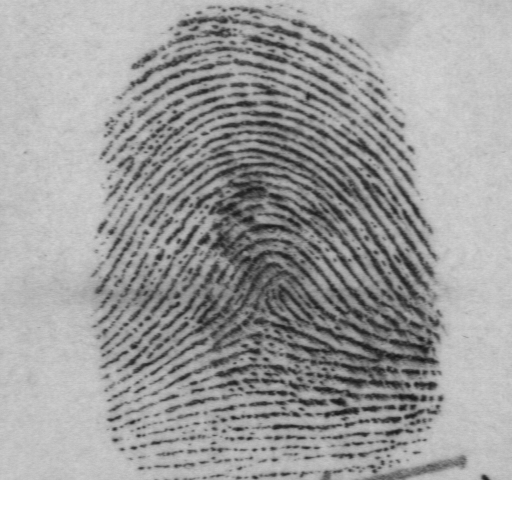

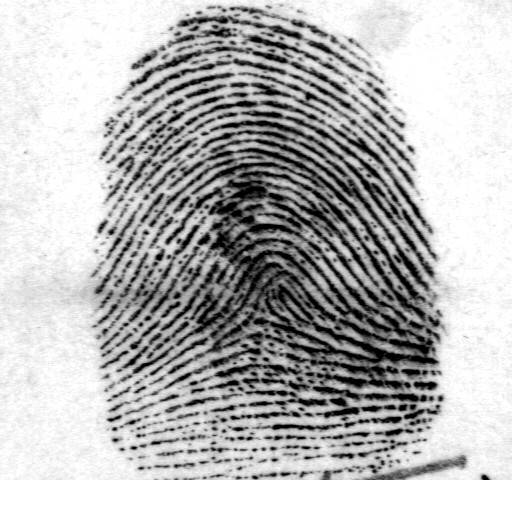

In [9]:
r_min=np.min(img)
r_max=np.max(img)

s_min=0
s_max=255

#cutoff fraction
cutoff_fraction=0.03

#no. of pixels to ignore
total_pixels=img.size
num_ignore=int(total_pixels*cutoff_fraction)

hist, bin_edges=np.histogram(img.flatten(), bins=256, range=[0,256])

#lower and upper cutoff values
lower_cutoff=np.searchsorted(np.cumsum(hist),num_ignore)
higher_cutoff=255-np.searchsorted(np.cumsum(hist[::1]),num_ignore)

print('lower cutoff value',lower_cutoff)
print('higher cutoff value',higher_cutoff)

#contrast stretching only within the cutoff range
img_clipped=np.clip(img,lower_cutoff,higher_cutoff)
r_min_clipped=np.min(img_clipped)
r_max_clipped=np.max(img_clipped)

stretched2=((img_clipped-r_min_clipped)*((s_max-s_min)/(r_max_clipped-r_min_clipped))+s_min).astype(np.uint8)

cv2_imshow(img)
cv2_imshow(stretched2)

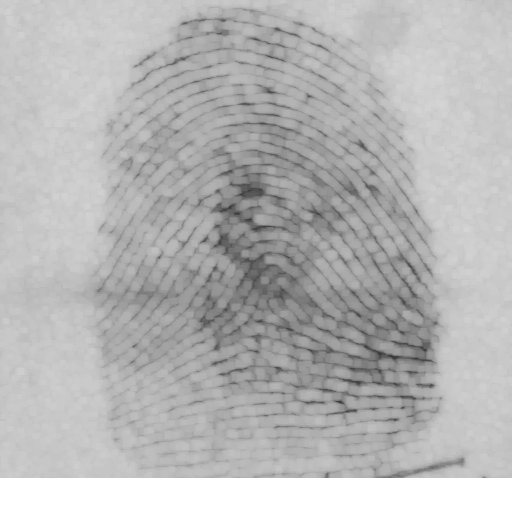

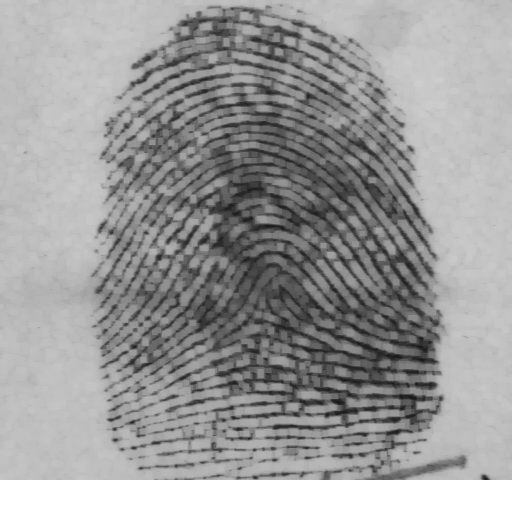

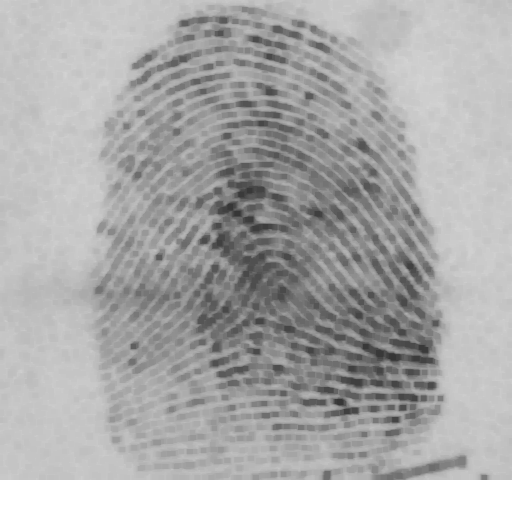

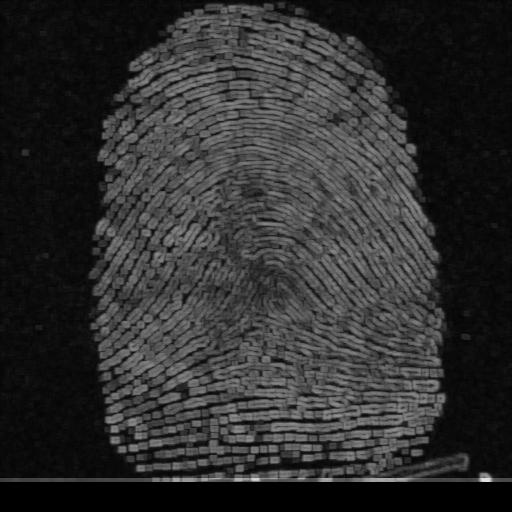

In [10]:
kernel = np.ones((5,5),np.uint8)

dilation = cv2.dilate(img,kernel,iterations = 1)
cv2_imshow(dilation)

opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
cv2_imshow(opening)

closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
cv2_imshow(closing)

gradient = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)
cv2_imshow(gradient)


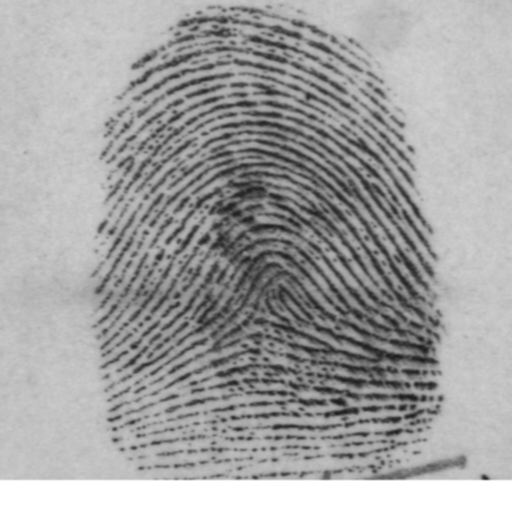

In [11]:
removeNoise=cv2.GaussianBlur(img,(3,3),0)
cv2_imshow(removeNoise)

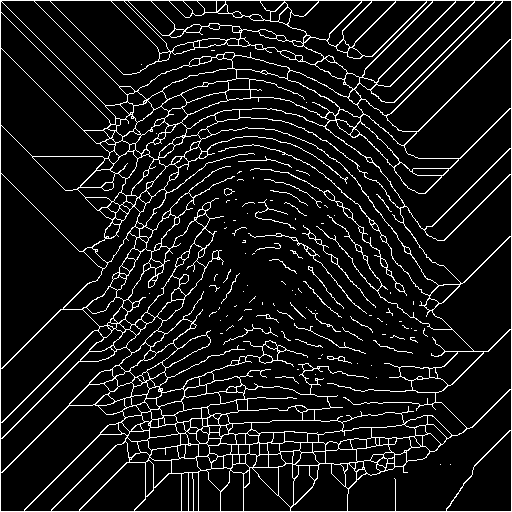

In [12]:
# Thinning (skeletonization)
thinned = cv2.ximgproc.thinning(stretched2)
cv2_imshow(thinned)

Detected 21913 minutiae points.


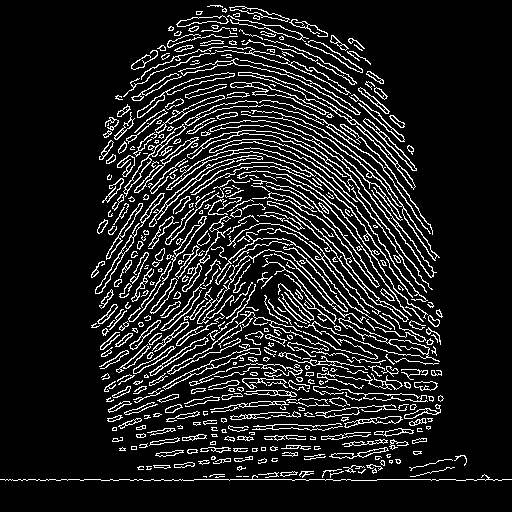

In [13]:
def extract_minutiae(thinned_img):
    minutiae = []
    rows, cols = thinned_img.shape

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if thinned_img[i, j] == 255:  # White pixel in skeleton
                neighbors = thinned_img[i-1:i+2, j-1:j+2]
                neighbor_count = np.sum(neighbors) // 255  # Count white neighbors
                if neighbor_count == 1:  # Ridge ending
                    minutiae.append((i, j, 'ending'))
                elif neighbor_count > 2:  # Bifurcation
                    minutiae.append((i, j, 'bifurcation'))
    return minutiae

minutiae_points = extract_minutiae(thinned)
print(f"Detected {len(minutiae_points)} minutiae points.")

edges=cv2.Canny(removeNoise,100,200)
cv2_imshow(edges)

In [14]:
def load_and_process_fingerprints(folder_path):
    features_list = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        fingerprint = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        thinned = cv2.ximgproc.thinning(fingerprint)
        features = extract_minutiae(thinned)  # Extract minutiae points
        features_list.append(features)
    return features_list

In [17]:
def compare_minutiae(input_minutiae, stored_minutiae):
    matched_points = 0
    for point1 in input_minutiae:
        for point2 in stored_minutiae:
            if point1[:2] == point2[:2] and point1[2] == point2[2]:  # Match location and type
                matched_points += 1
    return matched_points / max(len(input_minutiae), len(stored_minutiae))


folder_path = '/content/drive/MyDrive/imgprocessing_project/Images dataset2/Nour'
folder_name = os.path.basename(folder_path)  # Extract folder name

dataset_features = load_and_process_fingerprints(folder_path)

# Process input fingerprint
input_thinned = cv2.ximgproc.thinning(img)
input_minutiae = extract_minutiae(input_thinned)

# Compare with dataset
threshold = 0.8  #threshold for matching
match_found = False


In [18]:
for idx, stored_features in enumerate(dataset_features):
    similarity_score = compare_minutiae(input_minutiae, stored_features)
    if similarity_score > threshold:
        print(f"Input fingerprint matches with {folder_name}'s fingerprint {idx + 1}.")
        match_found = True
        break  # Exit loop after the first match

if not match_found:
    print("No matching fingerprint found in the dataset.")

dataset_features = load_and_process_fingerprints(folder_path)

match_found = False
for idx, stored_features in enumerate(dataset_features):
    similarity_score = compare_minutiae(input_minutiae, stored_features)
    if similarity_score > threshold:
        print(f"Fingerprint matches with {folder_name}'s fingerprint {idx+1}.")
        match_found = True
        break

if not match_found:
    print(f"Fingerprint does not match {folder_name}'s folder.")

Input fingerprint matches with Nour's fingerprint 6.
Fingerprint matches with Nour's fingerprint 6.


In [ ]:
# import cv2
# import numpy as np
# import os
# from google.colab.patches import cv2_imshow
# from google.colab import drive

# drive.mount('/content/drive')

# img_path = '/content/drive/MyDrive/imgprocessing_project/Images dataset2/Nour/T_f0731_02.png'
# img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# cv2_imshow(img)

# # Thinning the input fingerprint
# input_thinned = cv2.ximgproc.thinning(img)
# cv2_imshow(input_thinned)

# # Extract minutiae points for the input fingerprint
# input_minutiae = []
# rows, cols = input_thinned.shape
# for i in range(1, rows - 1):
#     for j in range(1, cols - 1):
#         if input_thinned[i, j] == 255:  # White pixel in skeleton
#             neighbors = input_thinned[i-1:i+2, j-1:j+2]
#             neighbor_count = np.sum(neighbors) // 255  # Count white neighbors
#             if neighbor_count == 1:  # Ridge ending
#                 input_minutiae.append((i, j, 'ending'))
#             elif neighbor_count > 2:  # Bifurcation
#                 input_minutiae.append((i, j, 'bifurcation'))

# main_folder_path = '/content/drive/MyDrive/imgprocessing_project/Images dataset2'

# # Iterate through all subfolders and files in the dataset
# match_found = False
# threshold = 0.8  # Set a similarity threshold

# for root, dirs, files in os.walk(main_folder_path):
#     folder_name = os.path.basename(root)  # Extract folder name
#     for filename in files:
#         file_path = os.path.join(root, filename)
#         fingerprint = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
#         if fingerprint is not None:
#             # Display the fingerprint being compared
#             print(f"Comparing with fingerprint from {folder_name}/{filename}")
#             cv2_imshow(fingerprint)

#             # Thinning the fingerprint from the dataset
#             thinned = cv2.ximgproc.thinning(fingerprint)
#             cv2_imshow(thinned)

#             # Extract minutiae points
#             stored_minutiae = []
#             rows, cols = thinned.shape
#             for i in range(1, rows - 1):
#                 for j in range(1, cols - 1):
#                     if thinned[i, j] == 255:  # White pixel in skeleton
#                         neighbors = thinned[i-1:i+2, j-1:j+2]
#                         neighbor_count = np.sum(neighbors) // 255  # Count white neighbors
#                         if neighbor_count == 1:  # Ridge ending
#                             stored_minutiae.append((i, j, 'ending'))
#                         elif neighbor_count > 2:  # Bifurcation
#                             stored_minutiae.append((i, j, 'bifurcation'))

#             # Compare minutiae points between input and stored fingerprint
#             matched_points = 0
#             for point1 in input_minutiae:
#                 for point2 in stored_minutiae:
#                     if point1[:2] == point2[:2] and point1[2] == point2[2]:  # Match location and type
#                         matched_points += 1

#             similarity_score = matched_points / max(len(input_minutiae), len(stored_minutiae))
#             print(f"Similarity score with {folder_name}/{filename}: {similarity_score}")

#             # Check if similarity score exceeds threshold
#             if similarity_score > threshold:
#                 print(f"Input fingerprint matches with {folder_name}'s fingerprint {filename}.")
#                 match_found = True
#                 break
#     if match_found:
#         break

# if not match_found:
#     print("No matching fingerprint found in the dataset.")


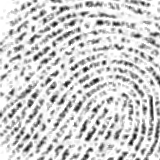

In [ ]:
img=cv2.imread('/content/drive/MyDrive/imgprocessing_project/Images dataset/train_data/person1/00000_00.bmp', cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

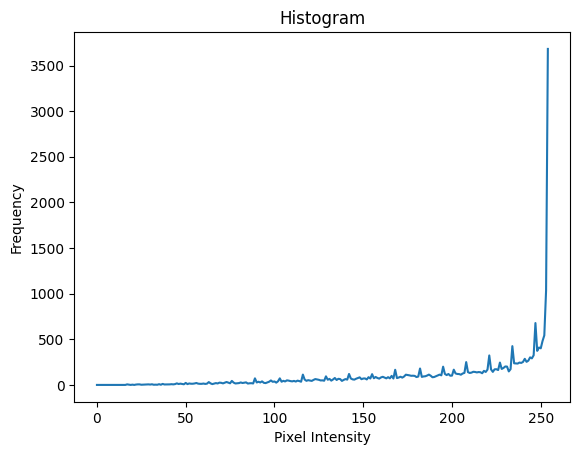

In [ ]:
# Histogram calculation
hist = cv2.calcHist([img], [0], None, [255], [0, 256])
plt.plot(hist)
plt.title('Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

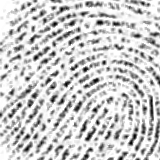

In [ ]:
r_min = np.min(img)
r_max = np.max(img)
s_min = 0
s_max = 255

#contrast stretching
stretched1 = ((img - r_min) * ((s_max - s_min) / (r_max - r_min)) + s_min).astype(np.uint8)
cv2_imshow(stretched1)
cv2.waitKey(0)
cv2.destroyAllWindows()

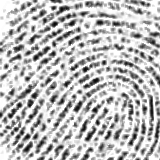

In [ ]:
# CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_img = clahe.apply(img)
cv2_imshow(enhanced_img)

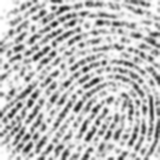

In [ ]:
# Gaussian Blur for noise reduction
blurred_img = cv2.GaussianBlur(enhanced_img, (5, 5), 0)
cv2_imshow(blurred_img)

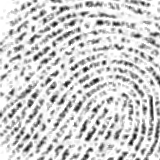

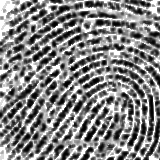

In [ ]:
# Histogram Equalization
equalized = cv2.equalizeHist(img)

cv2_imshow(img)
cv2_imshow(equalized)

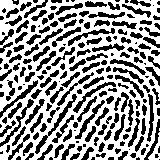

In [ ]:
# Adaptive Thresholding
binary_img = cv2.adaptiveThreshold(
    blurred_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
)
cv2_imshow(binary_img)

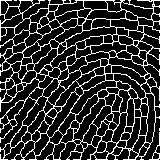

In [ ]:
# Thinning (Skeletonization)
thinned = cv2.ximgproc.thinning(binary_img)
cv2_imshow(thinned)

In [ ]:
def enhance_image(image):# using CLAHE, Gaussian Blur, and sharpening.

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(image)
    blurred_img = cv2.GaussianBlur(enhanced_img, (5, 5), 0)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened_img = cv2.filter2D(blurred_img, -1, kernel)
    return sharpened_img

In [ ]:
def preprocess_image(image):
    enhanced_img = enhance_image(image)
    binary_img = cv2.adaptiveThreshold(
        enhanced_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    thinned_img = cv2.ximgproc.thinning(binary_img)
    return thinned_img

In [ ]:
def extract_minutiae(thinned_img):# (ridge endings and bifurcations).
    minutiae = []
    rows, cols = thinned_img.shape

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if thinned_img[i, j] == 255:  # White pixel in skeleton
                neighbors = thinned_img[i-1:i+2, j-1:j+2]
                neighbor_count = np.sum(neighbors) // 255  # Count white neighbors
                if neighbor_count == 1:  # Ridge ending
                    minutiae.append((i, j, 'ending'))
                elif neighbor_count > 2:  # Bifurcation
                    minutiae.append((i, j, 'bifurcation'))
    return minutiae

In [ ]:
def extract_features(image):# additional features: minutiae counts, orientation, and ridge density.

    thinned_img = preprocess_image(image)
    minutiae = extract_minutiae(thinned_img)

    ridge_endings = len([m for m in minutiae if m[2] == 'ending'])
    bifurcations = len([m for m in minutiae if m[2] == 'bifurcation'])# Minutiae counts

    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    orientation = np.arctan2(sobely, sobelx).mean()

    ridge_density = np.sum(thinned_img) / 255

    return [ridge_endings, bifurcations, orientation, ridge_density]

In [ ]:
def augment_image(image):

    augmented_images = [image]
    for angle in [15, -15]:
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, matrix, (w, h))
        augmented_images.append(rotated)
    flipped = cv2.flip(image, 1)
    augmented_images.append(flipped)
    return augmented_images


In [ ]:
def process_dataset(folder_path):
    feature_vectors = []
    labels = []

    for folder_name in os.listdir(folder_path):
        person_path = os.path.join(folder_path, folder_name)
        if os.path.isdir(person_path):
            for file_name in os.listdir(person_path):
                file_path = os.path.join(person_path, file_name)
                fingerprint = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if fingerprint is None:
                    continue

                # Augment fingerprints
                augmented_images = augment_image(fingerprint)

                for img in augmented_images:
                    feature_vector = extract_features(img)
                    feature_vectors.append(feature_vector)
                    labels.append(folder_name)

    return np.array(feature_vectors), np.array(labels)

In [ ]:
train_folder_path = '/content/drive/MyDrive/imgprocessing_project/Images dataset/train_data'

X, y = process_dataset(train_folder_path)

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grids = {
    "KNN": {"n_neighbors": [3, 5, 7]},
    "SVM": {"C": [0.1, 1, 10], "kernel": ['linear', 'rbf']},
    "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]}
}

best_models = {}
for model_name, param_grid in param_grids.items():
    if model_name == "KNN":
        model = KNeighborsClassifier()
    elif model_name == "SVM":
        model = SVC(probability=True)
    elif model_name == "Random Forest":
        model = RandomForestClassifier(random_state=42)

    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"{model_name} Best Parameters: {grid_search.best_params_}")

# Evaluate
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy * 100:.2f}%")

KNN Best Parameters: {'n_neighbors': 5}
SVM Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Random Forest Best Parameters: {'max_depth': 10, 'n_estimators': 200}
KNN Accuracy: 31.25%
SVM Accuracy: 32.03%
Random Forest Accuracy: 41.88%


In [ ]:
def test_fingerprint(image_path, models):
    # Test a new against trained models.
    fingerprint = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if fingerprint is None:
        print("Error: Image not found or unable to read!")
        return

    feature_vector = [extract_features(fingerprint)]

    # Predict using trained models
    for model_name, model in models.items():
        predicted_label = model.predict(feature_vector)
        print(f"{model_name} Prediction: {predicted_label[0]}")

test_image_path = '/content/drive/MyDrive/imgprocessing_project/Images dataset/test_data/p5.bmp'
test_fingerprint(test_image_path, best_models)


KNN Prediction: person10
SVM Prediction: person5
Random Forest Prediction: person5
